In [1]:
### Normalizing Flow

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from getdist import plots, MCSamples
import getdist
from multiprocessing import Pool
from getdist import plots, MCSamples, WeightedSamples

import sys
import time
from cocoa_emu import *
from cocoa_emu.emulator import NNEmulator, GPEmulator
from cocoa_emu.data_model import LSST_3x2

import emcee
import time

# Now normalizing flow
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tf.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import Callback

from numpy import linalg
import scipy

%matplotlib inline

In [7]:
### Functions

class Callback(tfk.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self._loss = []
        self._epoch = []
        self.n_epochs = self.params['epochs']
        print('[                    ] Training... ',end="")
        
    def on_epoch_begin(self, epoch, logs=None):
        progress = int(epoch/self.n_epochs*20)
        ret = '\r['
        for i in range(progress):
            ret += '#'
        for i in range(20-progress):
            ret += ' '
        print(ret+'] Training... (epoch {}/{})'.format(epoch,self.n_epochs),end="")

    def on_epoch_end(self, epoch, logs=None):
        self._loss.append(logs['loss'])
        self._epoch.append(epoch)

    def on_train_end(self, logs=None):
        print('\r'+'[####################] Completed!                          ')
        fig,ax1 = plt.subplots(1,1)
        
        ax1.set_title('loss vs. epoch')
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('loss')
        ax1.plot(self._epoch,self._loss)
        
class No_Plot_Callback(tfk.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.n_epochs = self.params['epochs']
        print('[                    ] Training... ',end="")
        
    def on_epoch_begin(self, epoch, logs=None):
        progress = int(epoch/self.n_epochs*20)
        ret = '\r['
        for i in range(progress):
            ret += '#'
        for i in range(20-progress):
            ret += ' '
        print(ret+'] Training... (epoch {}/{})'.format(epoch,self.n_epochs),end="")

    def on_train_end(self, logs=None):
        print('\r'+'[####################] Completed!                             ')

def pregauss(chain,data):
    covmat = chain.cov().astype(np.float32)
    mean = chain.getMeans().astype(np.float32)
    
    # bijector time!
    # TriL means the cov matrix is lower triangular. Inverse is easy to compute that way
    # the cholesky factorization takes a positive definite hermitian matrix M (like the covmat) to LL^T with L lower triangluar
    gauss_approx = tfd.MultivariateNormalTriL(loc=mean,scale_tril=tf.linalg.cholesky(covmat))
    bijector = gauss_approx.bijector

    # now map the data
    new_data = bijector.inverse(data.astype(np.float32))
    return new_data,bijector

def train(base,data,bijectors,batch_size,n_epochs,feedback=True):
    val_split = 0.1
    # stack data
    _data = []
    dim = 0
    for key in data.getParamNames().list():
        nsamples=len(data[key])
        _data.append(data[key])
        dim += 1

    xdata = np.stack(_data, axis=-1)

    x_data,bij = pregauss(data,xdata)

    #create data set with weights.
    weights = data.weights.astype(np.float32)
    
    ## NN setup
    target_distribution = tfd.TransformedDistribution(
        distribution=base,
        bijector=tfb.Chain(bijectors)) 

    # Construct model.
    x_ = tfk.Input(shape=(dim,), dtype=tf.float32)
    log_prob_ = target_distribution.log_prob(x_)
    model = tfk.Model(x_, log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
                  loss=lambda _, log_prob: -log_prob) 
    if(feedback):
        print('---   Model compiled   ---')
        print(" - N samples = {}".format(nsamples))
        if weights.all()==weights[0]:
            print(" - Uniform weights = {}".format(weights[0]))
        else:
            print(" - Non-uniform weights")
        print(" - Pre-Gaussian Map = True\n")
        print(" - Validation split = {}".format(val_split))
        print(' - Number MAFS = {} '.format(int(len(bijectors)/2)))
        print(' - Trainable parameters = {} \n'.format(model.count_params()))

    # now perform the fit
    if(feedback):
        model.fit(x=x_data,
                  y=np.zeros((nsamples, dim),dtype=np.float32),
                  batch_size=batch_size,
                  epochs=n_epochs,
                  steps_per_epoch=int(nsamples/batch_size*0.8),  # Usually `n // batch_size`.
                  validation_split=val_split,
                  shuffle=True,
                  verbose=False,
                  callbacks=[Callback(),tfk.callbacks.ReduceLROnPlateau()]) #, ydata
    if(not feedback):
        model.fit(x=x_data,
                  y=np.zeros((nsamples, dim),dtype=np.float32),
                  batch_size=batch_size,
                  epochs=n_epochs,
                  steps_per_epoch=int(nsamples/batch_size*0.8),  # Usually `n // batch_size`.
                  validation_split=val_split,
                  shuffle=True,
                  verbose=False,
                  callbacks=[No_Plot_Callback(),tfk.callbacks.ReduceLROnPlateau()]) #, ydata
        
    return(target_distribution,bij)

def setup(n_maf,n_params,permute,feedback=True):
    # Set up bijector MADE
    hidden_units=[n_params*2]*2
    if(feedback):
        print('---   MADE Info   ---')
        print(' - Hidden_units = {}'.format(hidden_units))
        print(' - Activation = {}\n'.format(tf.math.asinh))
    bijectors=[]
    if(permute==True):
        _permutations = [np.random.permutation(n_params) for _ in range(n_maf)]
    else:
        _permutations=False
    
    for i in range(n_maf):
        # the permutation part comes from the code M. Raveri wrote,
        if _permutations:
            #print(_permutations[i])
            bijectors.append(tfb.Permute(_permutations[i].astype(np.int32)))
        # rest by myself
        bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=tfb.AutoregressiveNetwork(params=2, event_shape=(n_params,), hidden_units=hidden_units, activation=tf.math.asinh, kernel_initializer='glorot_uniform')))
        
    return bijectors

def diff_boost(n_boost,chains):
    # get data
    chain1 = chains[0].samples
    chain2 = chains[1].samples
    w_chain1 = chains[0].weights
    w_chain2 = chains[1].weights
    ll_chain1 = chains[0].loglikes
    ll_chain2 = chains[1].loglikes
    
    planck_names = chains[0].getParamNames().getRunningNames()
    samples_names = chains[1].getParamNames().getRunningNames()
    if samples_names==['logA', 'ns', 'H0', 'omegab', 'omegac']:
        samples_names=['logA', 'ns', 'H0', 'omegabh2', 'omegach2']
    common_params = [param for param in planck_names if param in samples_names]

    idx1 = [planck_names.index(param) for param in common_params]
    idx2 = [samples_names.index(param) for param in common_params]
    assert len(idx1)==len(idx2)
    
    # ensure first chain is longer than the second.
    # Need to keep track if I flipped the data so I get the signs right (although in principle it doesn't matter, Its better for everyones results to look the same even if they import chains in different orders)
    flip=False
    if( len(chain1) < len(chain2) ):
        chain1,chain2 = chain2,chain1
        w_chain1,w_chain2 = w_chain2,w_chain1
        ll_chain1,ll_chain2 = ll_chain2,ll_chain1
        idx1,idx2 = idx2,idx1
        flip=True
    
    N1 = len(chain1)
    N2 = len(chain2)
    #print('N1 = {}'.format(N1))
    #print('N2 = {}'.format(N2))

    # set up parameter diff arrays
    diff = np.zeros((N1*n_boost,len(idx1)),dtype=np.float32)
    weights = np.zeros(N1*n_boost,dtype=np.float32)
    loglikes = np.zeros(N1*n_boost,dtype=np.float32)
        
    for i in range(n_boost):
        # find the range of indices to use for chain 2
        lower = int((i/n_boost)*N1)
        upper = lower+N1

        # compute stuff
        if flip==True:
            diff[i*N1:(i+1)*N1] = -chain1[:N1,idx1] + np.take(chain2[:,idx2], range(lower,upper), axis=0, mode='wrap')
        else:
            diff[i*N1:(i+1)*N1] = chain1[:N1,idx1] - np.take(chain2[:,idx2], range(lower,upper), axis=0, mode='wrap')
        weights[i*N1:(i+1)*N1] = w_chain1*np.take(w_chain2, range(lower,upper), mode='wrap')
        #if(ll_chain1 is not None and ll_chain2 is not None):
        #    loglikes[i*N1:(i+1)*N1] = ll_chain1+np.take(ll_chain2, range(lower,upper), mode='wrap')
    
    min_weight_ratio = min(chains[0].min_weight_ratio,
                               chains[1].min_weight_ratio)

    diff_samples = WeightedSamples(ignore_rows=0,
                                   samples=diff,
                                   weights=weights, loglikes=loglikes,
                                   name_tag=' ', label=' ',
                                   min_weight_ratio=min_weight_ratio)

    return diff_samples
    
def significance(trained_dist,bijector,nparams,alpha=0.32):
    # The alpha is used for beta function for the confidence. Raveri et. al. defaults to 0.32
    prob = trained_dist.prob(bijector.inverse(np.zeros(nparams,dtype=np.float32)))
    n_points = 10000
    n_pass = 0

    _s = trained_dist.sample(n_points)
    _v = trained_dist.prob(_s)
    for val in _v:
        if val>prob:
            n_pass+=1
    # use clopper-pearson to find confidence level
    low = scipy.stats.beta.ppf(alpha/2,float(n_pass),float(n_points-n_pass+1))
    high = scipy.stats.beta.ppf(1-alpha/2,float(n_pass+1),float(n_points-n_pass))

    # compute sigma based on gaussian
    n_sigma = np.sqrt(2)*scipy.special.erfinv(n_pass/n_points)
    sigma_high = np.sqrt(2)*scipy.special.erfinv(high)
    sigma_low = np.sqrt(2)*scipy.special.erfinv(low)
    
    return n_sigma,sigma_high,sigma_low

def plot_cosmo_contours(sample_list, legend_labels):
    names = ['logA', 'ns', 'H0', 'omegab', 'omegac']
    labels =  ['logA', 'ns', 'H0', 'omega b', 'omega c']
    
    cosmo_truth = [3.0675, 0.97, 69., 0.0228528, 0.1199772]
    
    truth_dict = {}
    for name, truth in zip(names, cosmo_truth):
        truth_dict[name] = truth
        
    getdist_samples = []
    for samples, legend_label in zip(sample_list, legend_labels):
        cosmo_samples = samples[:,:5]
        getdist_samples.append(MCSamples(samples=cosmo_samples,names = names, labels=labels, label=legend_label))
    
    g = plots.get_subplot_plotter()
    g.triangle_plot(getdist_samples, filled=True, markers=truth_dict)
    
    #plt.show()

In [3]:
## Import chains
d = '/home/grads/data/evan/mc_data/'
cl = [0.6827,0.9545,0.9973]

### open the planck 3x2 chain in getdist
path = '/home/grads/ownCloud/StatisticalProject/chains/plikHM_TTTEEE/base_plikHM_TTTEEE'
chain_1 = getdist.mcsamples.loadMCSamples(file_root=path, no_cache=True)

/home/grads/ownCloud/StatisticalProject/chains/plikHM_TTTEEE/base_plikHM_TTTEEE_3.txt
/home/grads/ownCloud/StatisticalProject/chains/plikHM_TTTEEE/base_plikHM_TTTEEE_4.txt
/home/grads/ownCloud/StatisticalProject/chains/plikHM_TTTEEE/base_plikHM_TTTEEE_2.txt
/home/grads/ownCloud/StatisticalProject/chains/plikHM_TTTEEE/base_plikHM_TTTEEE_1.txt
Removed no burn in


/home/grads/data/evan/mc_data/fiducial.txt
Removed no burn in
['omegabh2', 'omegach2', 'theta', 'tau', 'logA', 'ns', 'acib217', 'xi', 'asz143', 'aps100', 'aps143', 'aps143217', 'aps217', 'aksz', 'kgal100', 'kgal143', 'kgal143217', 'kgal217', 'galfTE100', 'galfTE100143', 'galfTE100217', 'galfTE143', 'galfTE143217', 'galfTE217', 'cal0', 'cal2', 'calPlanck']
['logA', 'ns', 'H0', 'omegab', 'omegac']
---   MADE Info   ---
 - Hidden_units = [8, 8]
 - Activation = <function asinh at 0x7f7d5549f440>

---   Model compiled   ---
 - N samples = 1128000
 - Non-uniform weights
 - Pre-Gaussian Map = True

 - Validation split = 0.1
 - Number MAFS = 8 
 - Trainable parameters = 1472 

[####################] Completed!                          


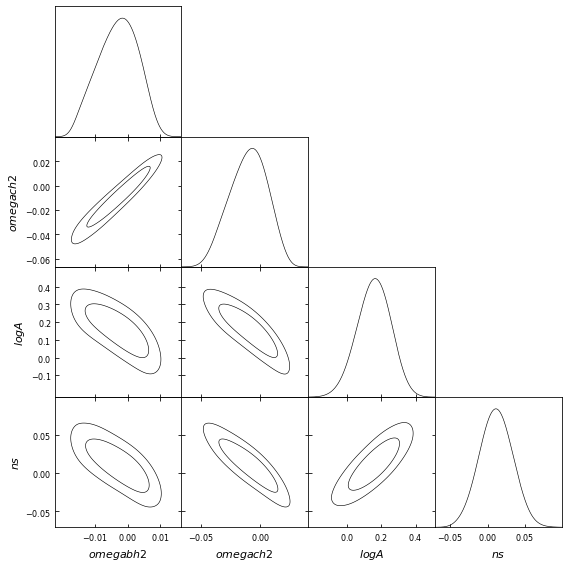

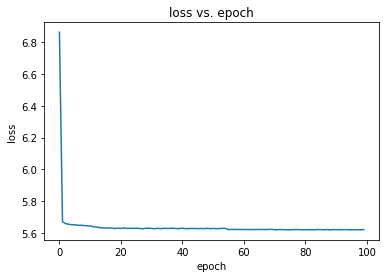

In [5]:
### Open the other chains only one at a time, do the flow.
chain_2 = getdist.mcsamples.loadMCSamples(file_root=d+'fiducial', no_cache=True)

idxs = np.arange(1,2,1)
#chain_2 = getdist.mcsamples.loadMCSamples(file_root=d+'noise_'+str(cl[0])+'_'+str(idx), no_cache=True)

# Parameter Difference

param_names_1 = chain_1.getParamNames().getRunningNames()
param_names_2 = chain_2.getParamNames().getRunningNames()
print(param_names_1)
print(param_names_2)

if param_names_1==['logA', 'ns', 'H0', 'omegab', 'omegac']:
    param_names_1=['logA', 'ns', 'H0', 'omegabh2', 'omegach2']
if param_names_2==['logA', 'ns', 'H0', 'omegab', 'omegac']:
    param_names_2=['logA', 'ns', 'H0', 'omegabh2', 'omegach2']

# find only the params in both chains
names = [param for param in param_names_1 if param in param_names_2]

diff = [diff_boost(1,[chain_1,chain_2])]
diff_chain = MCSamples(names=names,labels=names)
diff_chain.chains = diff
diff_chain.makeSingle()

g = plots.get_subplot_plotter()
g.settings.num_plot_contours = 2
g.triangle_plot(diff_chain,
                filled=False)

n_params = len(diff_chain.getParamNames().list())
dist = tfd.MultivariateNormalDiag(
    loc=np.zeros(n_params,dtype=np.float32), 
    scale_diag=np.ones(n_params,dtype=np.float32))

# make bijectors
bijectors = setup(2*n_params,n_params,True)

# train
trained_dist,bijector = train(dist,diff_chain,bijectors=bijectors,batch_size=5000,n_epochs=100)

# I'm going to do each confidence range separately, I would like to plot them a certain way at the end

#chain_3 = getdist.mcsamples.loadMCSamples(file_root=d+'noise_'+str(cl[1]), no_cache=True)
#chain_4 = getdist.mcsamples.loadMCSamples(file_root=d+'noise_'+str(cl[2]), no_cache=True)
#chain_5 = getdist.mcsamples.loadMCSamples(file_root=d+'noise_'+str(cl[3]), no_cache=True)

Removed no burn in
Removed no burn in


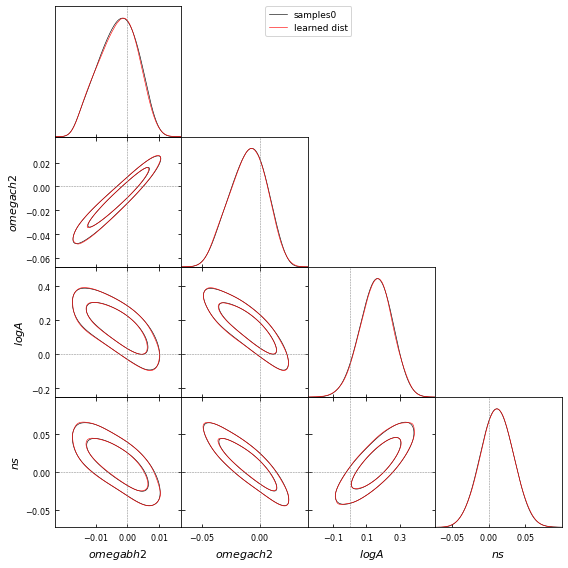

In [76]:
# Plot learned distribution
_samples = np.array(trained_dist.sample(10000))
_samples = bijector.forward(_samples)

sample = MCSamples(samples=_samples.numpy(), names=names,label='learned dist')
param_diff_chain = MCSamples(samples=diff_chain.samples,names=names,label='true dist')
g = getdist.plots.get_subplot_plotter()
g.settings.num_plot_contours = 2
g.triangle_plot([diff_chain,sample],
                params=names,
                filled=False,
                markers={_p:0 for _p in names})

In [85]:
nsigma,high,low = significance(trained_dist,bijector,n_params)
print('nsigma = {:.3f} +{:.3f}/-{:.3f}'.format(nsigma,high-nsigma,nsigma-low))

nsigma = 1.038 +0.010/-0.010


/home/grads/ownCloud/StatisticalProject/chains/plikHM_TTTEEE/base_plikHM_TTTEEE_3.txt
/home/grads/ownCloud/StatisticalProject/chains/plikHM_TTTEEE/base_plikHM_TTTEEE_4.txt
/home/grads/ownCloud/StatisticalProject/chains/plikHM_TTTEEE/base_plikHM_TTTEEE_2.txt
/home/grads/ownCloud/StatisticalProject/chains/plikHM_TTTEEE/base_plikHM_TTTEEE_1.txt
Removed no burn in


/home/grads/data/evan/mc_data/noise_0.6827_1.txt
Removed no burn in
[####################] Completed!                             


/home/grads/data/evan/mc_data/noise_0.6827_2.txt
Removed no burn in
[####################] Completed!                             


/home/grads/data/evan/mc_data/noise_0.6827_3.txt
Removed no burn in
[####################] Completed!                             


/home/grads/data/evan/mc_data/noise_0.6827_4.txt
Removed no burn in
[####################] Completed!                             


/home/grads/data/evan/mc_data/noise_0.6827_5.txt
Removed no burn in
[####################] Completed!  

/home/grads/.local/lib/python3.7/site-packages/getdist/plots.py:1745: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self.fig = plt.figure(figsize=figsize)


[####################] Completed!                             


/home/grads/data/evan/mc_data/noise_0.6827_22.txt
Removed no burn in
[####################] Completed!                             


/home/grads/data/evan/mc_data/noise_0.6827_23.txt
Removed no burn in
[####################] Completed!                             


/home/grads/data/evan/mc_data/noise_0.6827_24.txt
Removed no burn in
[####################] Completed!                             


/home/grads/data/evan/mc_data/noise_0.6827_25.txt
Removed no burn in
[####################] Completed!                             


/home/grads/data/evan/mc_data/noise_0.6827_26.txt
Removed no burn in
[####################] Completed!                             


/home/grads/data/evan/mc_data/noise_0.6827_27.txt
Removed no burn in
[####################] Completed!                             


/home/grads/data/evan/mc_data/noise_0.6827_28.txt
Removed no burn in
[####################] Completed!                             

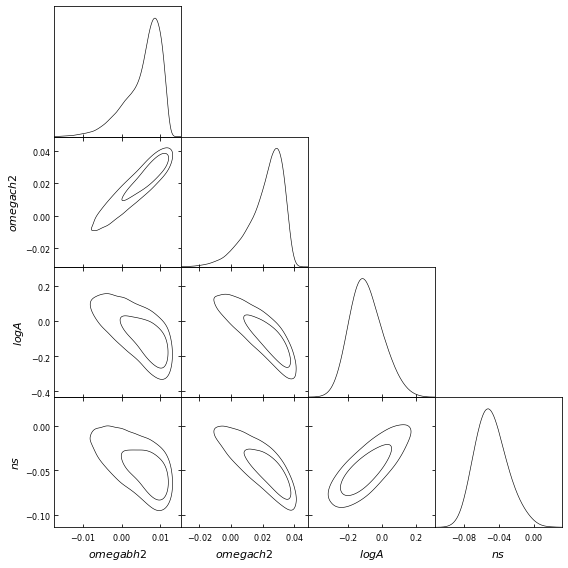

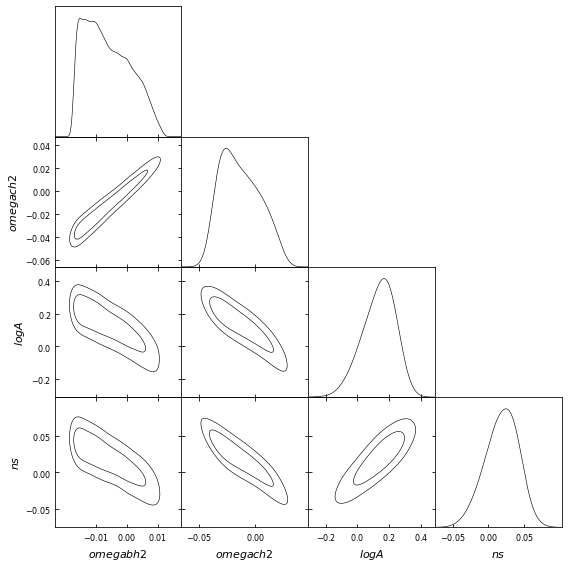

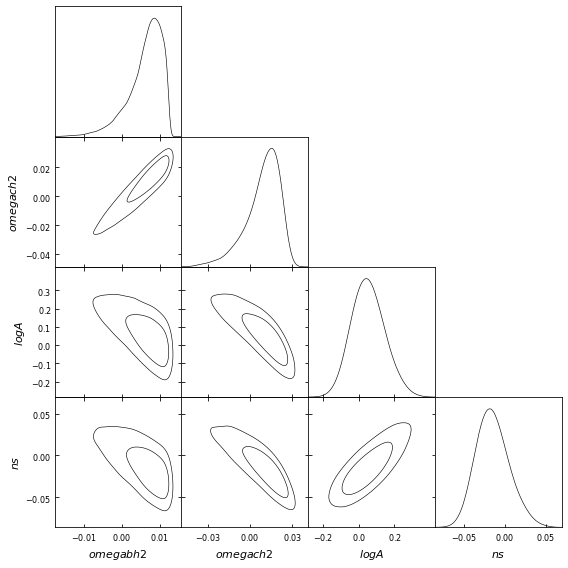

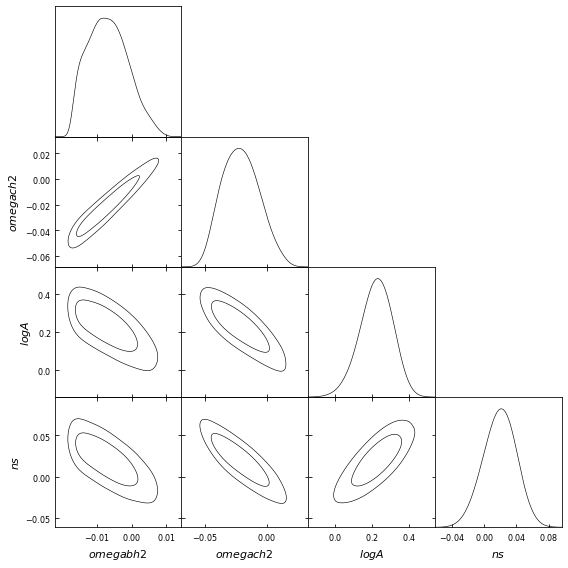

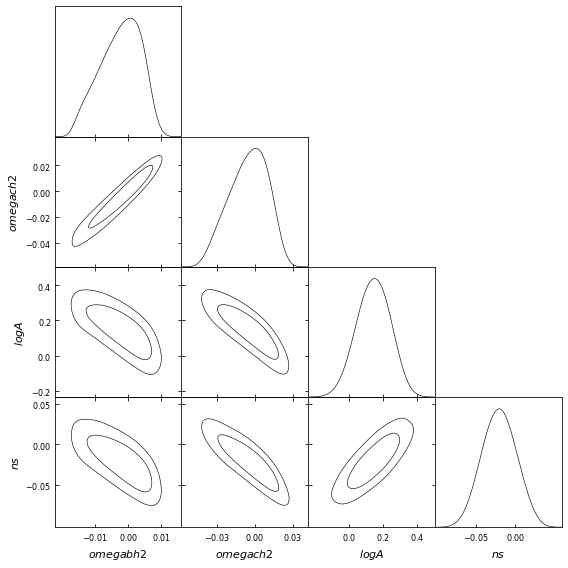

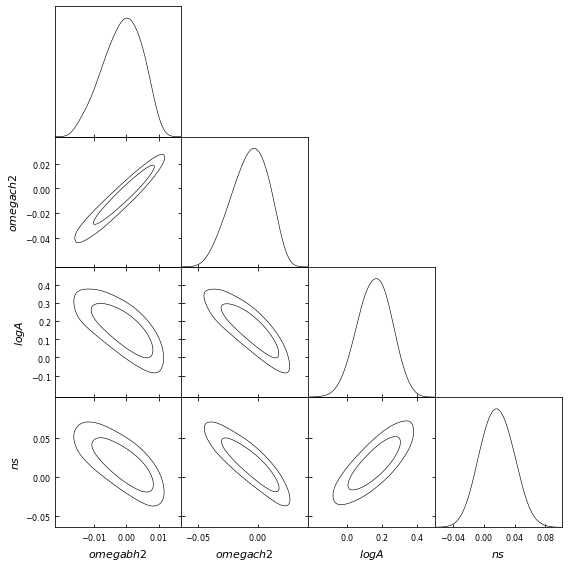

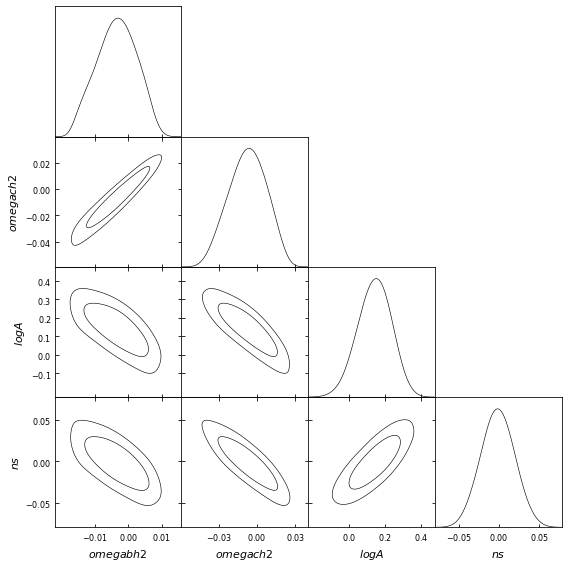

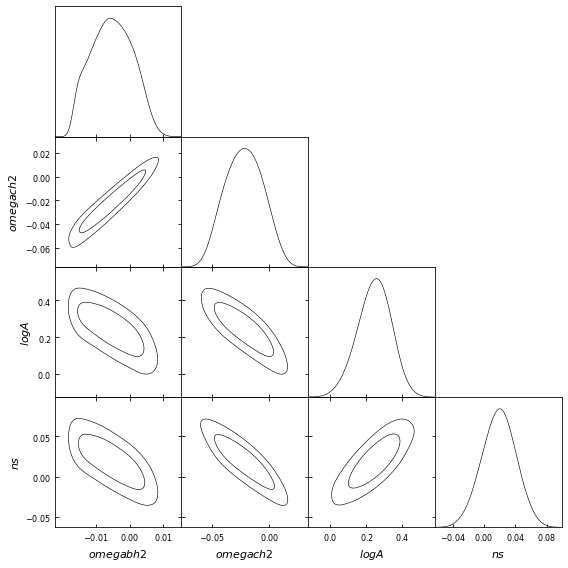

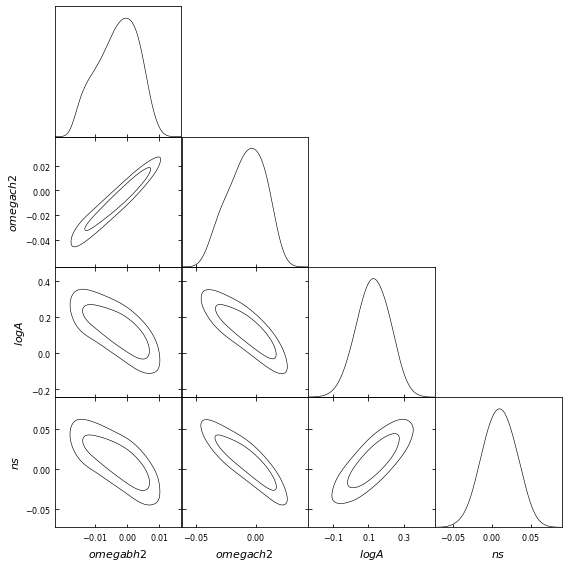

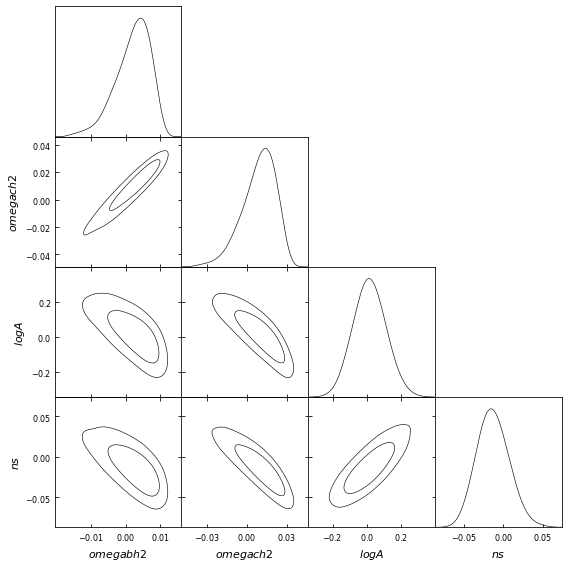

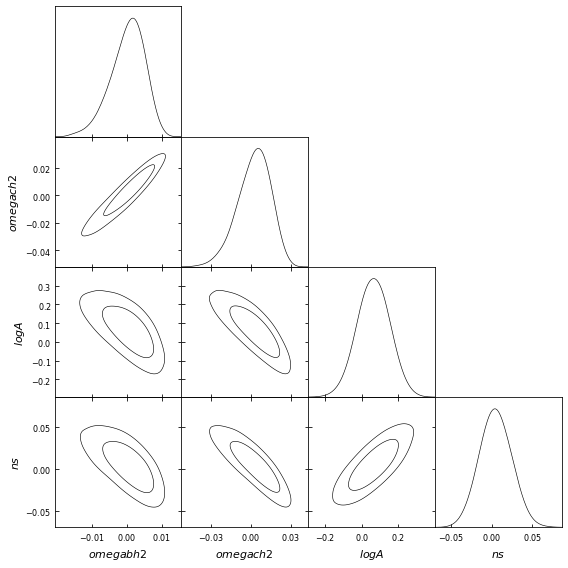

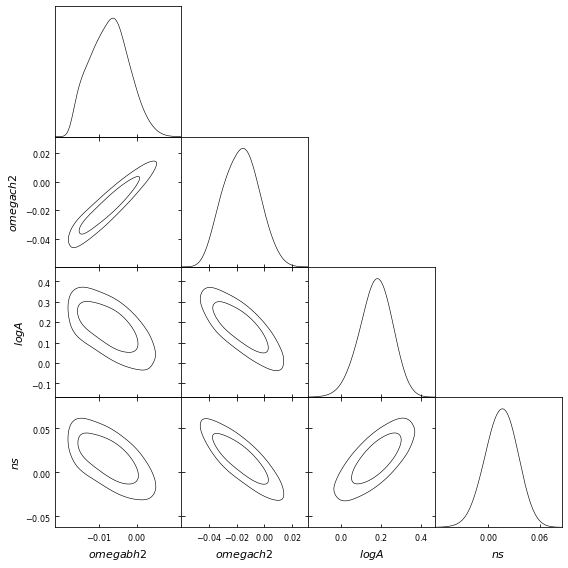

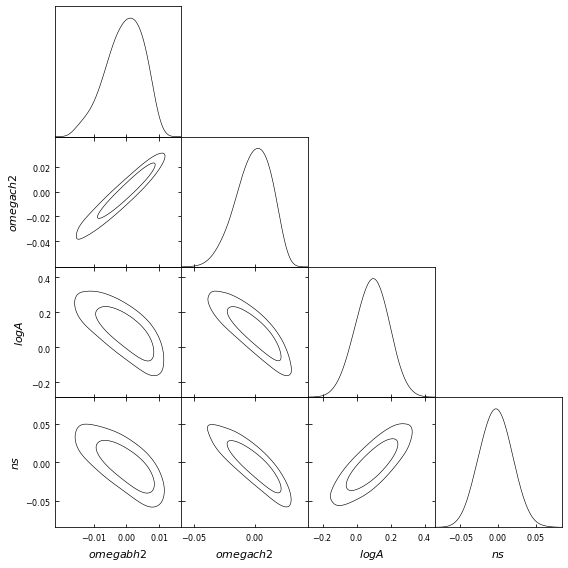

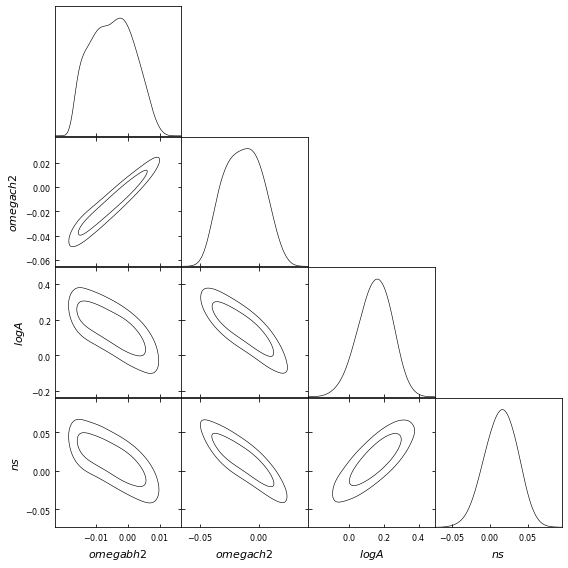

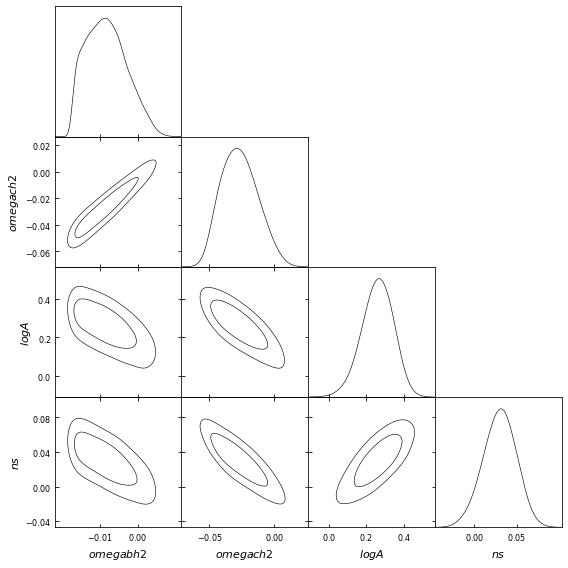

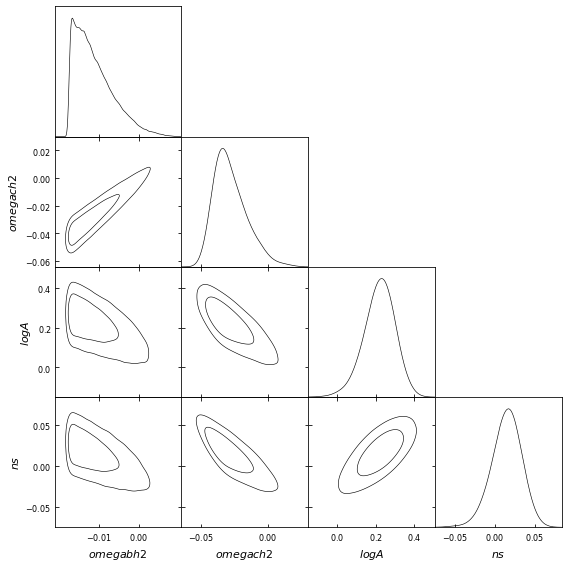

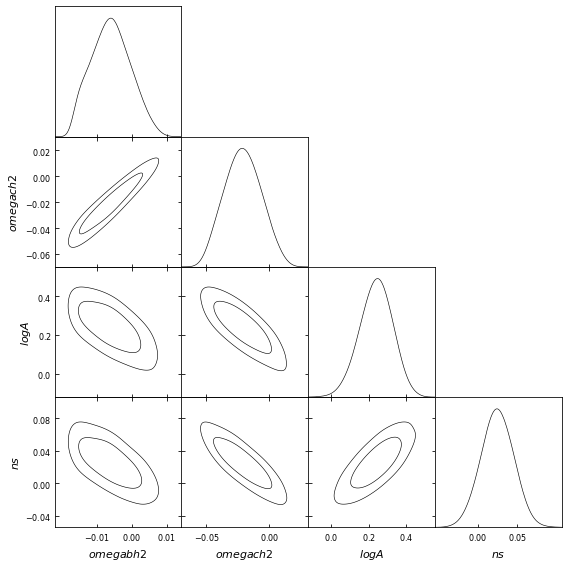

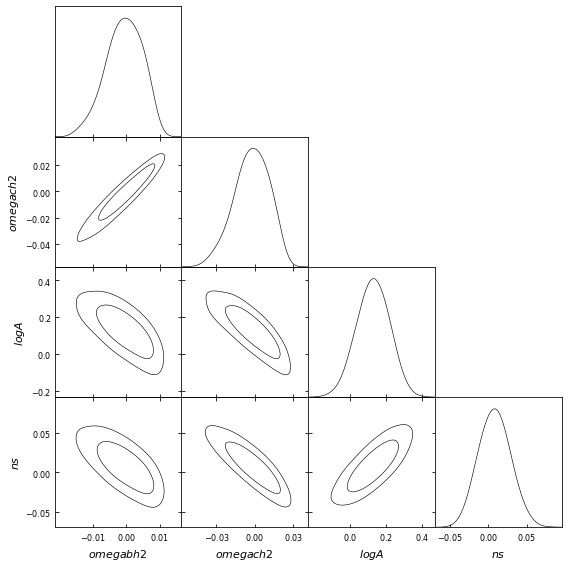

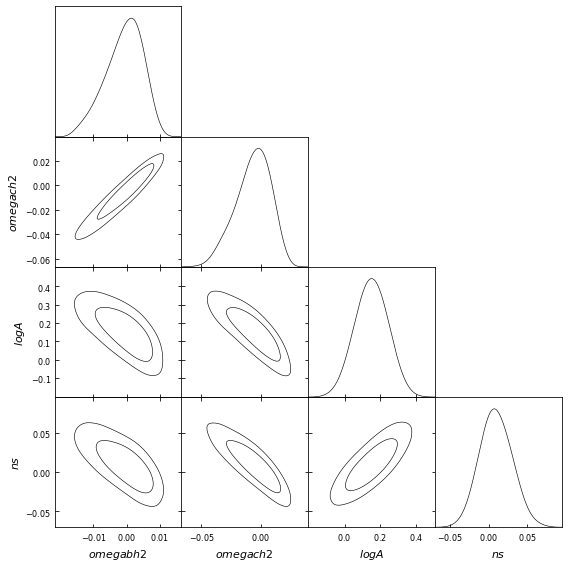

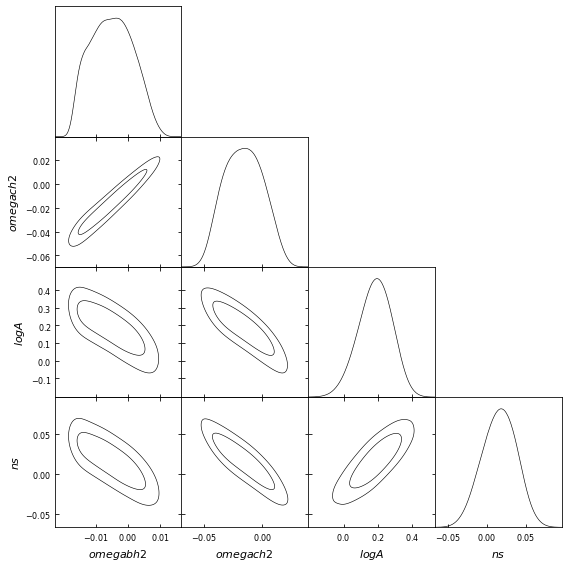

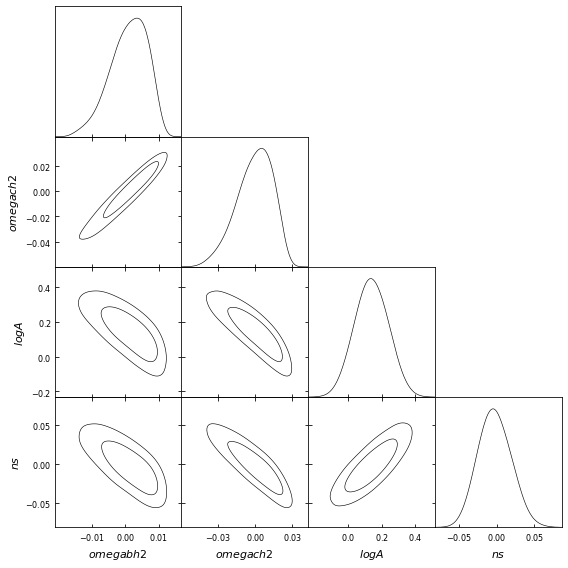

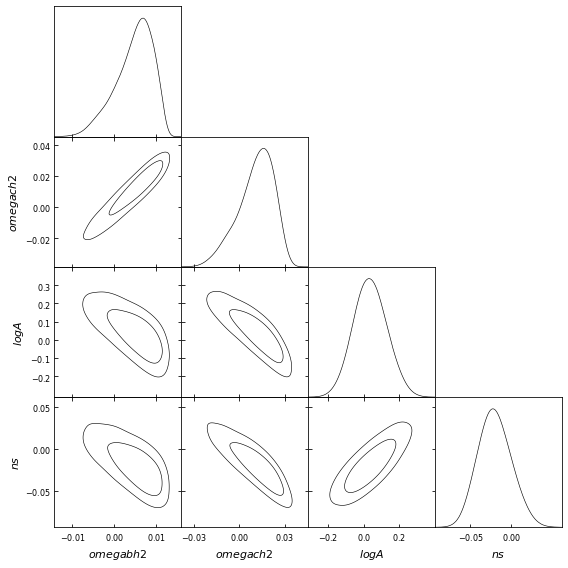

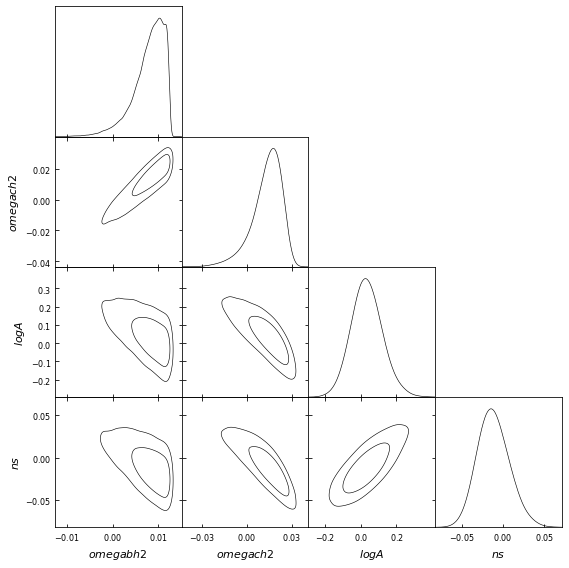

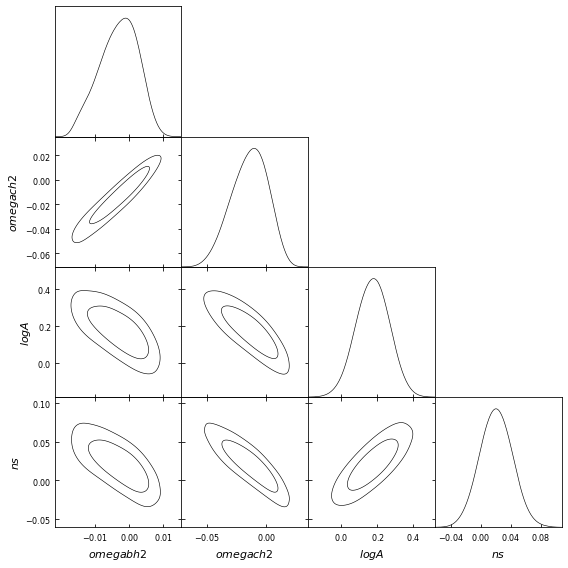

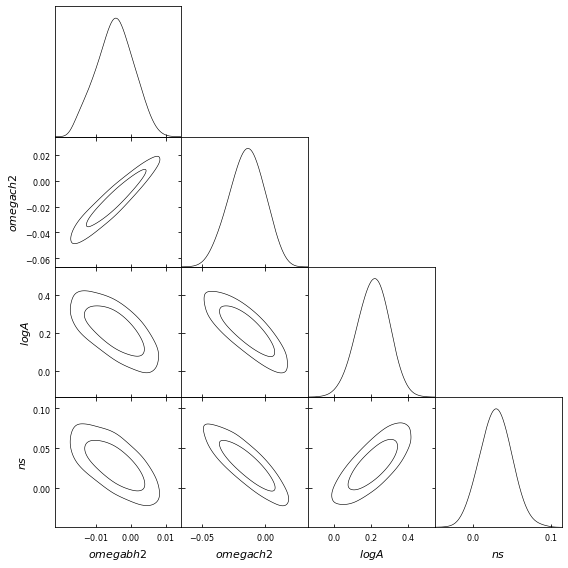

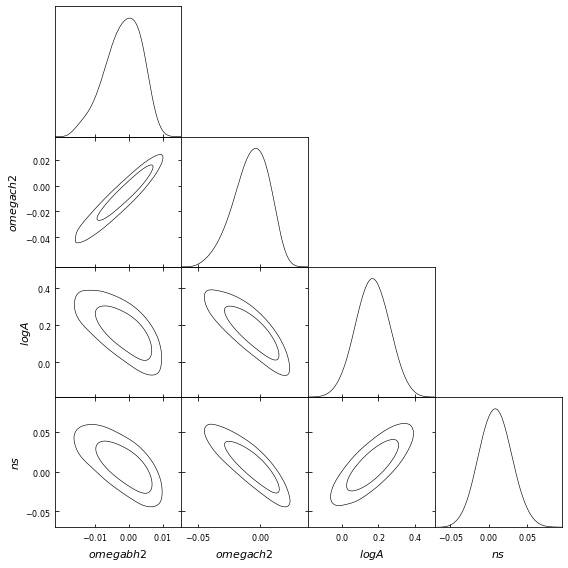

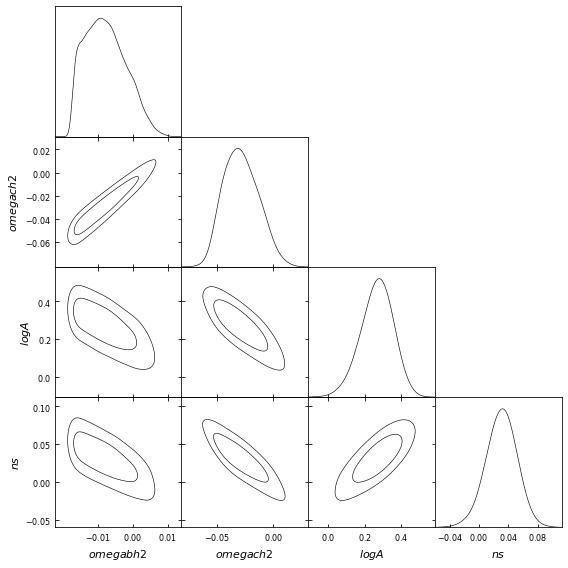

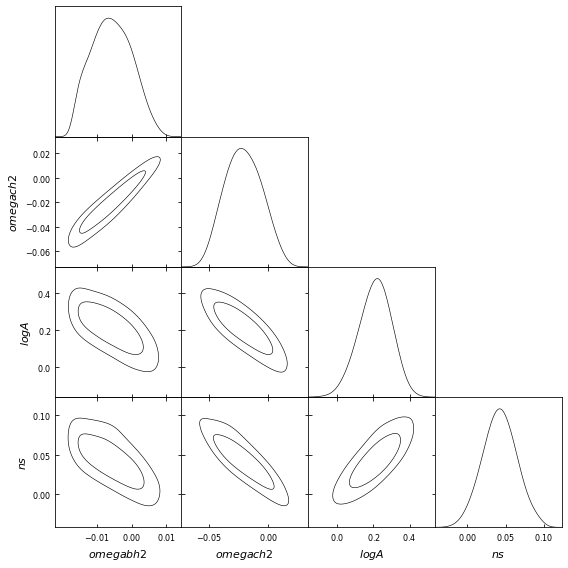

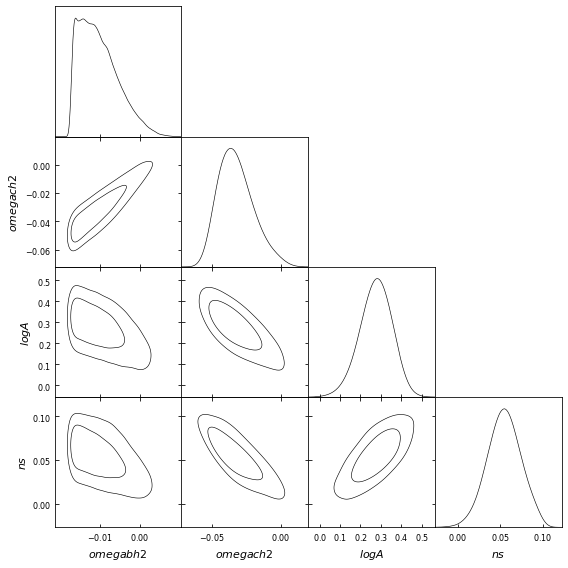

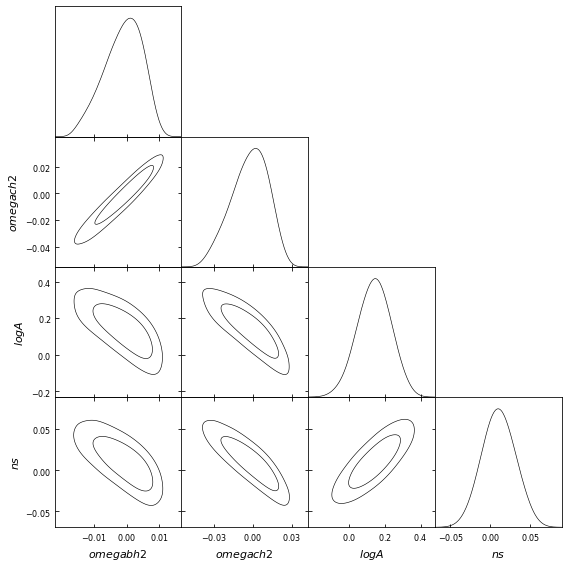

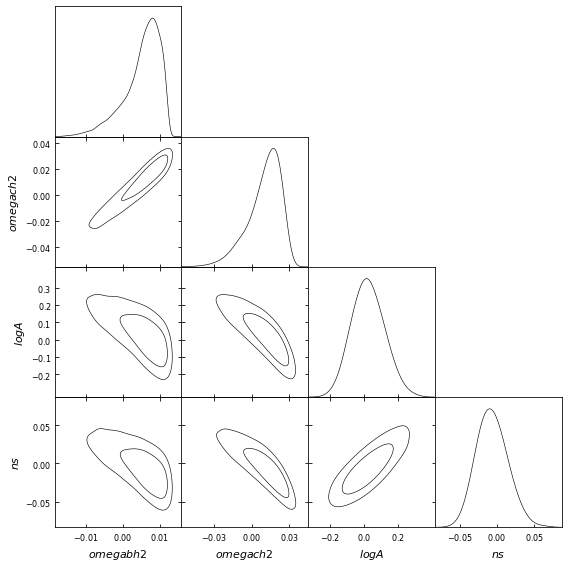

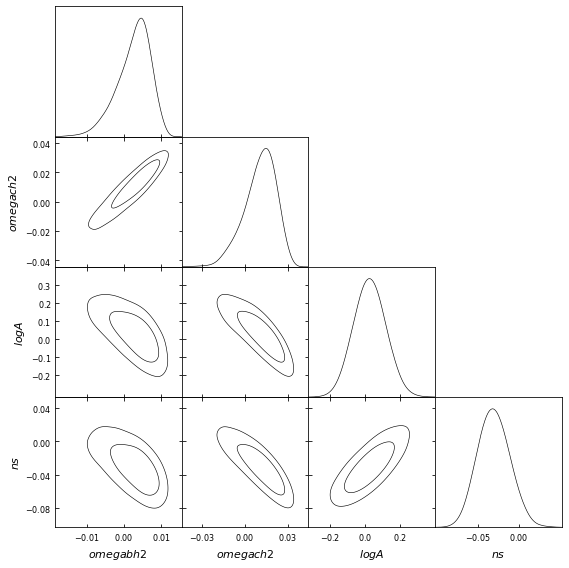

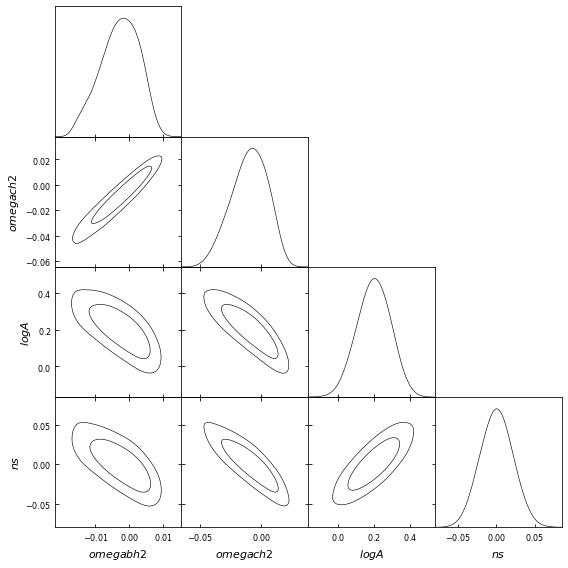

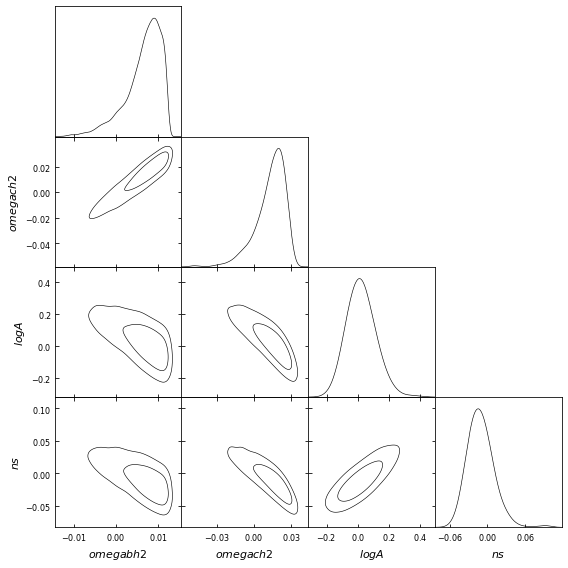

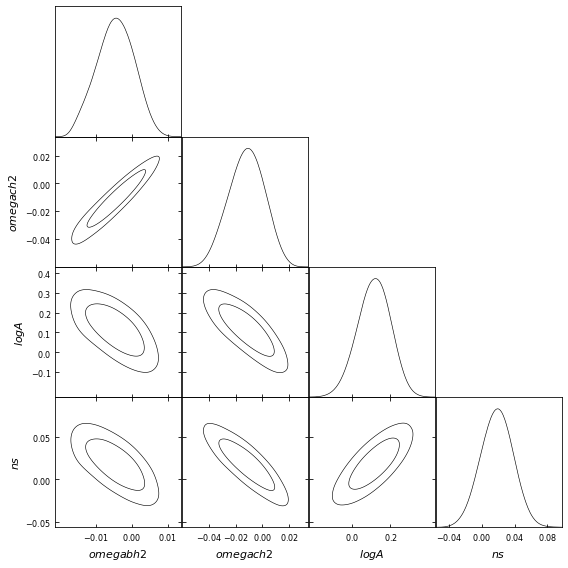

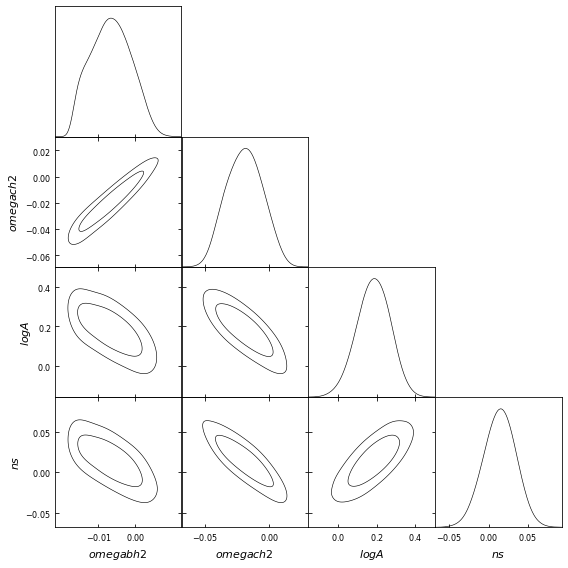

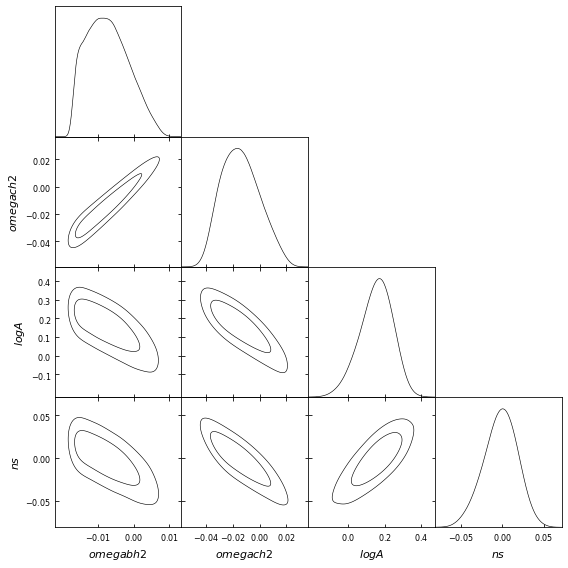

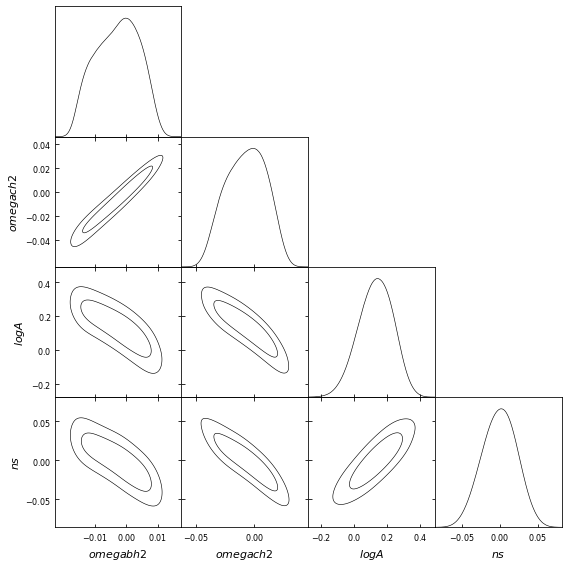

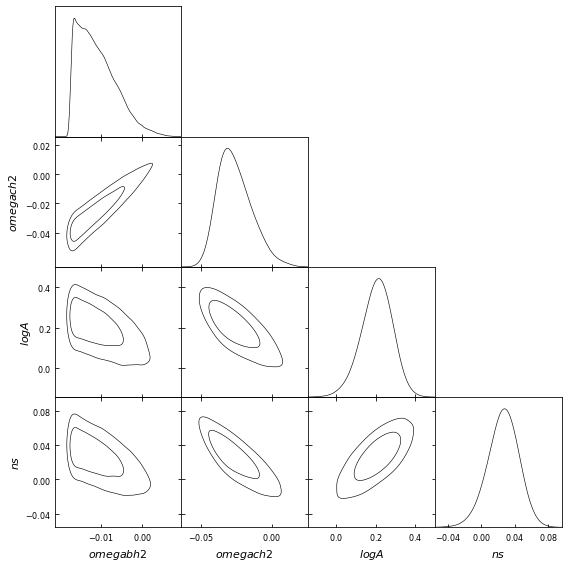

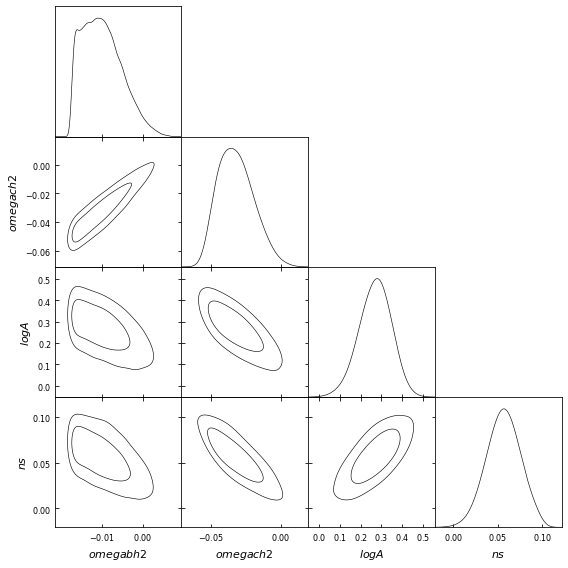

In [89]:
### Now lets do the same programattically for all datavectors.
### open the planck 3x2 chain in getdist
path = '/home/grads/ownCloud/StatisticalProject/chains/plikHM_TTTEEE/base_plikHM_TTTEEE'
chain_1 = getdist.mcsamples.loadMCSamples(file_root=path, no_cache=True)

idxs = np.arange(1,41,1)
p_shift_67 = np.zeros(40)
n_sigma_67 = np.zeros(40)

# I'm going to do each confidence range separately, I would like to plot them a certain way at the end
for idx in idxs:
    print('\n')#+str(idx)+'/40')
    chain_2 = getdist.mcsamples.loadMCSamples(file_root=d+'noise_'+str(cl[0])+'_'+str(idx), no_cache=True)

    # Parameter Difference

    param_names_1 = chain_1.getParamNames().getRunningNames()
    param_names_2 = chain_2.getParamNames().getRunningNames()

    if param_names_1==['logA', 'ns', 'H0', 'omegab', 'omegac']:
        param_names_1=['logA', 'ns', 'H0', 'omegabh2', 'omegach2']
    if param_names_2==['logA', 'ns', 'H0', 'omegab', 'omegac']:
        param_names_2=['logA', 'ns', 'H0', 'omegabh2', 'omegach2']

    # find only the params in both chains
    names = [param for param in param_names_1 if param in param_names_2]

    diff = [diff_boost(1,[chain_1,chain_2])]
    diff_chain = MCSamples(names=names,labels=names)
    diff_chain.chains = diff
    diff_chain.makeSingle()

    n_params = len(diff_chain.getParamNames().list())
    dist = tfd.MultivariateNormalDiag(
        loc=np.zeros(n_params,dtype=np.float32), 
        scale_diag=np.ones(n_params,dtype=np.float32))

    # make bijectors
    bijectors = setup(2*n_params,n_params,True,feedback=False)

    # train
    trained_dist,bijector = train(dist,diff_chain,bijectors=bijectors,batch_size=10000,n_epochs=100,feedback=False)
    
    n_sigma_67[idx-1],high,low = significance(trained_dist,bijector,n_params)

#chain_3 = getdist.mcsamples.loadMCSamples(file_root=d+'noise_'+str(cl[1]), no_cache=True)
#chain_4 = getdist.mcsamples.loadMCSamples(file_root=d+'noise_'+str(cl[2]), no_cache=True)
#chain_5 = getdist.mcsamples.loadMCSamples(file_root=d+'noise_'+str(cl[3]), no_cache=True)

[2.2767694, 1.11815687, 1.87713203, 1.73919767, 2.91123773, 1.34631795, 1.48781382, 2.05789723, 0.81250835, 1.26492002, 1.19573497, 1.51449635, 0.74445708, 0.75424853, 1.94979968, 2.11300897, 1.76359613, 1.22307863, 1.11558457, 1.09480974, 1.65709634, 1.44378309, 2.09692743, 0.85563447, 1.84525812, 1.38484457, 2.18895653, 1.51370767, 2.57930268, 2.01218917, 1.0738275, 1.70873526, 2.30440357, 1.24999876, 0.50081689, 1.33187886, 1.79722442, 1.24399881, 1.73523042, 2.58634424]


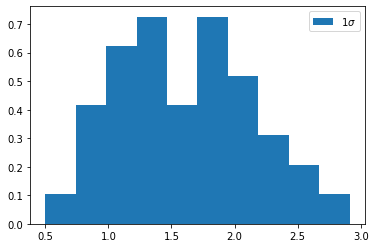

In [18]:
#
print(n_sigma_67)
plt.figure(1)
plt.hist(n_sigma_67,density=True,label='1$\sigma$')
plt.legend()
plt.ion()
plt.show()

In [92]:
### Now lets do the same programattically for all datavectors.

idxs = np.arange(1,41,1)
p_shift_95 = np.zeros(40)
n_sigma_95 = np.zeros(40)

# I'm going to do each confidence range separately, I would like to plot them a certain way at the end
for idx in idxs:
    print('\n')#+str(idx)+'/40')
    chain_2 = getdist.mcsamples.loadMCSamples(file_root=d+'noise_'+str(cl[1])+'_'+str(idx), no_cache=True)

    # Parameter Difference

    param_names_1 = chain_1.getParamNames().getRunningNames()
    param_names_2 = chain_2.getParamNames().getRunningNames()

    if param_names_1==['logA', 'ns', 'H0', 'omegab', 'omegac']:
        param_names_1=['logA', 'ns', 'H0', 'omegabh2', 'omegach2']
    if param_names_2==['logA', 'ns', 'H0', 'omegab', 'omegac']:
        param_names_2=['logA', 'ns', 'H0', 'omegabh2', 'omegach2']

    # find only the params in both chains
    names = [param for param in param_names_1 if param in param_names_2]

    diff = [diff_boost(1,[chain_1,chain_2])]
    diff_chain = MCSamples(names=names,labels=names)
    diff_chain.chains = diff
    diff_chain.makeSingle()

    n_params = len(diff_chain.getParamNames().list())
    dist = tfd.MultivariateNormalDiag(
        loc=np.zeros(n_params,dtype=np.float32), 
        scale_diag=np.ones(n_params,dtype=np.float32))

    # make bijectors
    bijectors = setup(2*n_params,n_params,True,feedback=False)

    # train
    trained_dist,bijector = train(dist,diff_chain,bijectors=bijectors,batch_size=10000,n_epochs=100,feedback=False)
    
    n_sigma_95[idx-1],high,low = significance(trained_dist,bijector,n_params)

#chain_3 = getdist.mcsamples.loadMCSamples(file_root=d+'noise_'+str(cl[1]), no_cache=True)
#chain_4 = getdist.mcsamples.loadMCSamples(file_root=d+'noise_'+str(cl[2]), no_cache=True)
#chain_5 = getdist.mcsamples.loadMCSamples(file_root=d+'noise_'+str(cl[3]), no_cache=True)



/home/grads/data/evan/mc_data/noise_0.9545_1.txt
Removed no burn in
[####################] Completed!                             


/home/grads/data/evan/mc_data/noise_0.9545_2.txt
Removed no burn in
[####################] Completed!                             


/home/grads/data/evan/mc_data/noise_0.9545_3.txt
Removed no burn in
[####################] Completed!                             


/home/grads/data/evan/mc_data/noise_0.9545_4.txt
Removed no burn in
[####################] Completed!                             


/home/grads/data/evan/mc_data/noise_0.9545_5.txt
Removed no burn in
[####################] Completed!                             


/home/grads/data/evan/mc_data/noise_0.9545_6.txt
Removed no burn in
[####################] Completed!                             


/home/grads/data/evan/mc_data/noise_0.9545_7.txt
Removed no burn in
[####################] Completed!                             


/home/grads/data/evan/mc_data/noise_0.9545_8.txt
Removed no burn in

[1.28326286, 1.7665716, 1.44591872, 1.98450115, 1.33309692, 1.96425955, 1.66556544, 1.83706703, 1.40272118, 0.68332737, 1.14092773, 1.59193193, 1.38028146, 1.49123427, 1.38484457, 1.50665154, 1.23777365, 1.34880378, 1.09275815, 0.86945191, 1.43741538, 1.50548278, 1.47170706, 2.56223808, 1.38779329, 1.77136515, 1.51174007, 1.90101537, 1.66707245, 2.23374282, 1.22972527, 1.29274289, 3.89059189, 0.91784504, 1.43917834, 1.6036102, 2.36152387, 1.12238213, 0.81372938, 1.71035634]


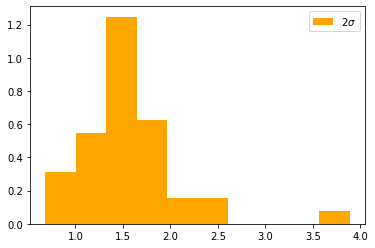

In [22]:
##
print(n_sigma_95)
plt.figure(2)
plt.hist(n_sigma_95,density=True,label='2$\sigma$',color='orange')
plt.legend()
plt.ion()
plt.show()

In [94]:
### Now lets do the same programattically for all datavectors.
idxs = np.arange(1,41,1)
p_shift_99 = np.zeros(40)
n_sigma_99 = np.zeros(40)

# I'm going to do each confidence range separately, I would like to plot them a certain way at the end
for idx in idxs:
    print('\n')#+str(idx)+'/40')
    chain_2 = getdist.mcsamples.loadMCSamples(file_root=d+'noise_'+str(cl[2])+'_'+str(idx), no_cache=True)

    # Parameter Difference

    param_names_1 = chain_1.getParamNames().getRunningNames()
    param_names_2 = chain_2.getParamNames().getRunningNames()

    if param_names_1==['logA', 'ns', 'H0', 'omegab', 'omegac']:
        param_names_1=['logA', 'ns', 'H0', 'omegabh2', 'omegach2']
    if param_names_2==['logA', 'ns', 'H0', 'omegab', 'omegac']:
        param_names_2=['logA', 'ns', 'H0', 'omegabh2', 'omegach2']

    # find only the params in both chains
    names = [param for param in param_names_1 if param in param_names_2]

    diff = [diff_boost(1,[chain_1,chain_2])]
    diff_chain = MCSamples(names=names,labels=names)
    diff_chain.chains = diff
    diff_chain.makeSingle()

    n_params = len(diff_chain.getParamNames().list())
    dist = tfd.MultivariateNormalDiag(
        loc=np.zeros(n_params,dtype=np.float32), 
        scale_diag=np.ones(n_params,dtype=np.float32))

    # make bijectors
    bijectors = setup(2*n_params,n_params,True,feedback=False)

    # train
    trained_dist,bijector = train(dist,diff_chain,bijectors=bijectors,batch_size=10000,n_epochs=100,feedback=False)
    
    n_sigma_99[idx-1],high,low = significance(trained_dist,bijector,n_params)

#chain_3 = getdist.mcsamples.loadMCSamples(file_root=d+'noise_'+str(cl[1]), no_cache=True)
#chain_4 = getdist.mcsamples.loadMCSamples(file_root=d+'noise_'+str(cl[2]), no_cache=True)
#chain_5 = getdist.mcsamples.loadMCSamples(file_root=d+'noise_'+str(cl[3]), no_cache=True)



/home/grads/data/evan/mc_data/noise_0.9973_1.txt
Removed no burn in
[####################] Completed!                             


/home/grads/data/evan/mc_data/noise_0.9973_2.txt
Removed no burn in
[####################] Completed!                             


/home/grads/data/evan/mc_data/noise_0.9973_3.txt
Removed no burn in
[####################] Completed!                             


/home/grads/data/evan/mc_data/noise_0.9973_4.txt
Removed no burn in
[####################] Completed!                             


/home/grads/data/evan/mc_data/noise_0.9973_5.txt
Removed no burn in
[####################] Completed!                             


/home/grads/data/evan/mc_data/noise_0.9973_6.txt
Removed no burn in
[####################] Completed!                             


/home/grads/data/evan/mc_data/noise_0.9973_7.txt
Removed no burn in
[####################] Completed!                             


/home/grads/data/evan/mc_data/noise_0.9973_8.txt
Removed no burn in

[1.54850815, 0.99302043, 1.59059833, 1.95063904, 1.35380061, 1.78230198, 1.17423727, 1.85148368, 0.9733085, 2.02468227, 0.80243738, 1.9863002, 0.79932843, 1.52283496, 1.59774383, 1.28126671, 2.01218917, 1.77256992, 1.51056232, 0.9714987, 1.57872129, 1.9574039, 2.2307152, 0.79141819, 2.1153515, 0.54595045, 1.62435531, 1.51845395, 1.16950557, 0.99384158, 1.45164622, 1.28354844, 1.19753011, 0.93168372, 1.05418112, 1.99356147, 1.45996388, 1.85707841, 1.07964566, 1.57915722]


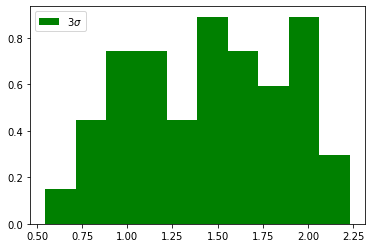

In [21]:
##
print(n_sigma_99)
plt.figure(3)
plt.hist(n_sigma_99,density=True,label='3$\sigma$',color='green')
plt.legend()
plt.ion()
plt.show()

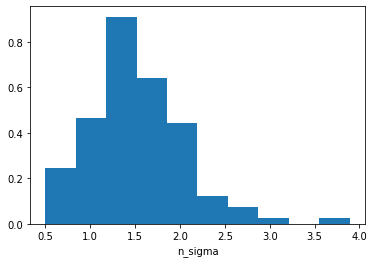

In [8]:
### THESE VALUES COPIED AS TO NOT RUN THE FLOWS AGAIN
n_sigma_67 = [2.2767694, 1.11815687, 1.87713203, 1.73919767, 2.91123773, 1.34631795,
 1.48781382, 2.05789723, 0.81250835, 1.26492002, 1.19573497, 1.51449635,
 0.74445708, 0.75424853, 1.94979968, 2.11300897, 1.76359613, 1.22307863,
 1.11558457, 1.09480974, 1.65709634, 1.44378309, 2.09692743, 0.85563447,
 1.84525812, 1.38484457, 2.18895653, 1.51370767, 2.57930268, 2.01218917,
 1.0738275, 1.70873526, 2.30440357, 1.24999876, 0.50081689, 1.33187886,
 1.79722442, 1.24399881, 1.73523042, 2.58634424]
n_sigma_95 = [1.28326286, 1.7665716,  1.44591872, 1.98450115, 1.33309692, 1.96425955,
 1.66556544, 1.83706703, 1.40272118, 0.68332737, 1.14092773, 1.59193193,
 1.38028146, 1.49123427, 1.38484457, 1.50665154, 1.23777365, 1.34880378,
 1.09275815, 0.86945191, 1.43741538, 1.50548278, 1.47170706, 2.56223808,
 1.38779329, 1.77136515, 1.51174007, 1.90101537, 1.66707245, 2.23374282,
 1.22972527, 1.29274289, 3.89059189, 0.91784504, 1.43917834, 1.6036102,
 2.36152387, 1.12238213, 0.81372938, 1.71035634]
n_sigma_99 = [1.54850815, 0.99302043, 1.59059833, 1.95063904, 1.35380061, 1.78230198,
 1.17423727, 1.85148368, 0.9733085,  2.02468227, 0.80243738, 1.9863002,
 0.79932843, 1.52283496, 1.59774383, 1.28126671, 2.01218917, 1.77256992,
 1.51056232, 0.9714987,  1.57872129, 1.9574039,  2.2307152,  0.79141819,
 2.1153515,  0.54595045, 1.62435531, 1.51845395, 1.16950557, 0.99384158,
 1.45164622, 1.28354844, 1.19753011, 0.93168372, 1.05418112, 1.99356147,
 1.45996388, 1.85707841, 1.07964566, 1.57915722]
###

plt.figure(7)
plt.hist(np.ndarray.flatten(np.array([n_sigma_67,n_sigma_95,n_sigma_99])), 10, density=True, histtype='bar', stacked=True, label=['1$\sigma$','2$\sigma$','3$\sigma$'])
plt.xlabel('n_sigma')
plt.show()

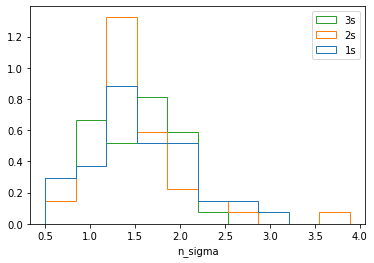

In [14]:
plt.figure(5)
plt.hist([n_sigma_67,n_sigma_95,n_sigma_99], 10, density=True, histtype='step', stacked=False, label=['1s','2s','3s'])
plt.legend()
plt.xlabel('n_sigma')
plt.show()